# Исследование взаимосвязи популярности игр от жанра, платформы и региона реализации.

<a id='section1'></a>
## 1. Знакомство с данными.

Загрузим необходимые бибилиотеки, прочитаем файл и сохраним его в переменную df


In [1]:
# импортируем необходимые для наших задач библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
pd.set_option('mode.chained_assignment', None)

In [2]:
# прочитаем файл games.csv и запишем его в переменную df
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv('games.csv')

In [3]:
# выведем для просмотра и ознакомления первые 10 строк датасета
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод:** По результатам знакомства с данными мы видим, что большая часть данных присутствует в датасете в полном объеме, а такжечто не все данные находятся в корректном и удобном для дальнейшего анализа виде. Поэтому на следующем этапе мы оценим какие данные мы сможем дополнить на основании имеющихся, от каких строк с пропущенными значениями мы сможем избавиться, и какие данные нам следует преобразовать. Ну и, соотвтетсвенно, проведем все эти манипуляции

<a id='section2'></a>
## 2. Предобработка данных.

Проведем первичную предобработку данных, а именно переименуем столбцы в более удобный для обработки вид, уберем по возможности пропущенные значения, и устраним дубликаты

### 2.1. Переименование столбцов.

In [5]:
# переводим названия всех столбцов в нижний регистр 
# и меняем название столбца Year_of_Release на release для дальнейшего удобства обращения к нему
df = df.rename(columns=lambda x: x.lower())
df = df.rename(columns={'year_of_release':'release'})
# проверяем изменились ли названия
df.columns 

Index(['name', 'platform', 'release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 2.2. Проверка дубликатов и заполнение пропусков.

In [6]:
# предварительно посмотрим в каких столбцах есть пропуски и в каком количестве
df.isna().sum()

name               2
platform           0
release          269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      6701
rating          6766
dtype: int64

Как мы видим, в последних трех столбцах с оценками от покупателей, критиков и рейтингом игры присутствует довольно большое количество пропущенных значений. Удалить такое количество пропущенных значений мы не можем, т.к. это довольно сильно скажется на репрезентативности наших данных и может исказить картину, также мы не можем заполнить данные пропущенные значения на основании имеющихся данных. Соответственно мы вынуждены оставить данные пропуски как есть.

Пропуски могли возникнуть в связи с тем, что:
* данные не были полностью выгружены для анализа
* игра была настолько не популярна, что количество ее оценок среди пользователей и/или критиков было недостаточным, чтобы попасть в глобальный рейтинг
* возрастной рейтинг мог быть не указан либо по причине, описанной выше, либо потом, что организация, занимающаяся оценкой игр находилась на одном рынке, а игра была выпущена для другого рынка 
* также из таблицы ниже видно, что в большинстве своем пропущены оценки на портативных консолях или приставках первых поколений, т.е. пропуски могут быть связаны с тем, какие консоли более актуальны в каком регионе и насколько старые эти консоли были на момент составления рейтинга

Аббревиатура tbd, как и RP, означает, что значение отсутствует. Их мы обработаем далее.

In [7]:
# построим таблицу с суммарными продажами по рынкам для игр с пропущенными оценками
df[(df.rating.isna()) & 
    (df.critic_score.isna()) &
    (df.user_score.isna())] \
    .pivot_table(index='platform',
                 values=['na_sales','eu_sales', 'jp_sales', 'other_sales'],
                 aggfunc='median') \
    .sort_values('jp_sales', ascending=False).head(10) #отсортируемся по медианному значению на JP рынке (на других рынка картина примерно та же)

,eu_sales,jp_sales,na_sales,other_sales
platform,,,,
NES,0.08,0.770,0.405,0.01
GB,0.00,0.405,0.000,0.01
SNES,0.00,0.290,0.000,0.00
WS,0.00,0.215,0.000,0.00
SAT,0.00,0.120,0.000,0.00
NG,0.00,0.100,0.000,0.00
DC,0.00,0.100,0.000,0.00
TG16,0.00,0.080,0.000,0.00
GEN,0.00,0.070,0.000,0.00


In [8]:
# Проверяем датасет на наличие явных дубликатов
df.duplicated().sum()

0

Явных дубликатов в нашем датасете нет, поэтому проверим названия игр на наличие неявных дубликатов.

In [9]:
# посчитаем количество каждого уникального значения в столбце name
df.name.value_counts()

Need for Speed: Most Wanted                         12
Ratatouille                                          9
LEGO Marvel Super Heroes                             9
FIFA 14                                              9
Madden NFL 07                                        9
                                                    ..
Jewels of the Tropical Lost Island                   1
Sherlock Holmes and the Mystery of Osborne House     1
The King of Fighters '95 (CD)                        1
Megamind: Mega Team Unite                            1
Haitaka no Psychedelica                              1
Name: name, Length: 11559, dtype: int64

Как мы видим в данном столбце присутствуют повторяющиеся полностью идентичные названия игр, проверим к какой платформе и году выпуска данные игры относятся на примере 3х первых игр

In [10]:
df[df.name == 'Need for Speed: Most Wanted']

,name,platform,release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


In [11]:
df[df.name == 'LEGO Marvel Super Heroes']

,name,platform,release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
730,LEGO Marvel Super Heroes,X360,2013.0,Action,1.24,0.79,0.00,0.19,80.0,7.6,E10+
945,LEGO Marvel Super Heroes,PS3,2013.0,Action,0.77,0.76,0.01,0.29,82.0,7.9,E10+
1139,LEGO Marvel Super Heroes,PS4,2013.0,Action,0.59,0.76,0.01,0.26,83.0,7.7,E10+
1959,LEGO Marvel Super Heroes,XOne,2013.0,Action,0.61,0.35,0.00,0.09,NaN,6.8,E10+
2313,LEGO Marvel Super Heroes,3DS,2013.0,Action,0.42,0.36,0.04,0.07,61.0,5.2,E10+
2778,LEGO Marvel Super Heroes,WiiU,2013.0,Action,0.31,0.35,0.02,0.06,82.0,8,E10+
3876,LEGO Marvel Super Heroes,PSV,2013.0,Action,0.11,0.29,0.00,0.11,NaN,NaN,NaN
5054,LEGO Marvel Super Heroes,DS,2013.0,Action,0.22,0.13,0.00,0.03,NaN,4.8,E10+
8369,LEGO Marvel Super Heroes,PC,2013.0,Action,0.04,0.12,0.00,0.01,78.0,8.1,E10+


Как мы видим, даже в случае полного совпадения названий игр и года их выпуска они различается платформой, для которой они были выпущены. Соответственно данные строки мы не можем считать дубликатами.


In [12]:
df[df.duplicated(subset=['name', 'platform'], keep=False)]

,name,platform,release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [13]:
# вычисляем какой процент пропуски в столбах составляют от общего кол-ва:
pd.DataFrame(round((df.isna().mean()*100),2)).rename(columns={0:'percents'}).style.background_gradient('coolwarm')

,percents
name,0.010000
platform,0.000000
release,1.610000
genre,0.010000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.320000
user_score,40.090000


Т.к. пропущенных значений в столбце чуть больше release 1.5% от общего количества, а в столбце name менее 0.01%, считаю допустимым исключить данные значения из дальнейшего анализа, т.к. в противном случае данные пропуски не дадут привести столбец release к числовому формату и будут давать шум при дальнейшем анализе.

Данные изменения мы сохраним в другую переменную, чтобы не менять изначальный датасет. С новой переменной в дальнейшем и будем работать.

Прежде, чем удалить игры, у которых отсутствует значение в столбце release, посмотрим какие значения преобладают в этих данных.


In [14]:
df[df.release.isna()].describe()

,release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,0.0,269.000000,269.000000,269.000000,269.000000,154.000000
mean,NaN,0.219888,0.090929,0.024907,0.032007,67.584416
std,NaN,0.424907,0.207933,0.090160,0.075546,14.828740
min,NaN,0.000000,0.000000,0.000000,0.000000,22.000000
25%,NaN,0.010000,0.000000,0.000000,0.000000,57.000000
50%,NaN,0.090000,0.020000,0.000000,0.010000,70.000000
75%,NaN,0.240000,0.100000,0.000000,0.030000,78.000000
max,NaN,4.260000,2.360000,0.770000,0.710000,94.000000


Как мы видим, большая часть игр, которая не имеет года выпуска, имеет в основном низкие продажи на всех рынках. Соответственно удаление этих данных с учетом их небольшого количества относительно общего количества позиций в датасете не должно сильно повлиять на общую картину наших данных

In [15]:
# исключаем пропущенные значения столбца release из датасета
good_df = df[(df.release.notna()) & (df.name.notna())]
# проверяем изменилось ли количество строк
good_df.shape

(16444, 11)

In [16]:
good_df.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Аббревиатура tbd расшифровывается как To Be Determined или проще говоря - "Будет определено". Т.е. в контексте данной задачи это означает, что значение также отсутствует на момент анализа, как и в том случае, если указано NaN.


In [17]:
# Проверяем в каком проценте строк от общего количества пропущены значения во всех трех последних столбцах.
round(good_df[(good_df.critic_score.isna()) & \
        ((good_df.user_score.isna()) | \
         (good_df.user_score == 'tbd')) & (good_df.rating.isna())] \
        .shape[0] / good_df.name.count() * 100, 2)


40.01

In [18]:
# заменим данные значения также на NaN для дальнейшего удобства обработки
good_df.loc[good_df['user_score'] == 'tbd', 'user_score'] = np.nan
# проверим удачно ли прошла замена
good_df[good_df['user_score'] == 'tbd']

,name,platform,release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Мы не можем исключить настолько большое количество пропусков и также не можем заполнить их на основании каких-либо других значений. Поэтому на данном этапе оставим их как есть.

### 2.3. Предварительный подсчет и категоризация данных.

В столбце rating данные указаны в абсолютно не репрезентативном виде. Для большей наглядности и лучшего понимания переведем их из шкалы ESRB в шкалу PEGI с прямым указанием возраста. Аббревиатура RP расшифровывается как "Rating Pending", т.е. "Рейтинг ожидается", поэтому данные значения также отнесем к категории неопознанных значений. Исходя из этого будем считать, что во всех строках, где указано RP или NaN рейтинг игры не определен

In [19]:
# создадим функцию, которая выполнит переименование обозначений.
def change_rating(row):
    try:
        if row.rating == 'EC':
            return '3+'
        elif row.rating == 'E' or row.rating == 'K-A':
            return '6+'
        elif row.rating == 'E10+':
            return '10+'
        elif row.rating == 'T':
            return '13+'
        elif row.rating == 'M':
            return '17+'
        elif row.rating == 'AO':
            return '18+'
        else:
            return 'Рейтинг не определен'
    except:
        return 'Ошибка переименования'
# применим данную функцию к новому столбцу, в котором и запишем новое обозначение рейтинга
good_df['age_rating'] = good_df.apply(change_rating, axis=1)

In [20]:
# проверяем удачно ли присвоились все значения и не сработал ли except
good_df.age_rating.unique()

array(['6+', 'Рейтинг не определен', '17+', '13+', '10+', '18+', '3+'],
      dtype=object)

Посчитаем общую сумму продаж по всем регионам для каждой игры и запишем ее в отдельный столбец

In [21]:
good_df['total_sales'] = good_df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis='columns')
# проверим удачно ли прошли изменения
good_df.head(1)

,name,platform,release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,age_rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,6+,82.54


### 2.4. Изменение типов данных столбцов.

Для дальнейшего удобства при обработке мы можем изменить формат нескольких столбцов

In [22]:
good_df.release = good_df.release.astype('int')
good_df.user_score = good_df.user_score.astype('float')

In [23]:
# проверяем удачно ли прошли изменения
good_df.dtypes

name             object
platform         object
release           int32
genre            object
na_sales        float64
eu_sales        float64
jp_sales        float64
other_sales     float64
critic_score    float64
user_score      float64
rating           object
age_rating       object
total_sales     float64
dtype: object

**Вывод:** В результате предобработки данных нам удалось:
        
* избавиться от пропущенных значений в столбцах name и release, т.к. количество пропусков было незначительным
* убрать текстовое обозначение пропущенных значений в столбцах user_score и rating, т.к. пропуски обозначались строчным типом данных в столдце, где все остальные значения вещественные (user_score)
* избавиться от дубликатов в столбце rating
* после вышеуказанных преобразований мы смогли перевести столбец release в тип данных int64, а столбец user_score в тип данных float64, что в дальнейшем облегчит работу с этими данными.
* был создан столбец с более репрезантативным обозначением возрастного рейтинга игр
* был создан столбец с суммой продаж конкретной игры по всем регионам

Данные неявные дубликаты могли возникнуть в результате человеческой ошибки - один и тот же возрастной рейтинг обозначен по-разному. Пропуски могли возникнуть в результате как человеческой ошибки, так и не корректной выгрузки данных из БД. То, что информация вообще отсутствует по некоторым играм тоже допускается, но маловероятно.

<a id='section3'></a>
## 3. Исследовательский анализ данных.

### 3.1. Изменение количества игр по годам.

Посмотрим как изменялось количество выпускаемых игр по годам

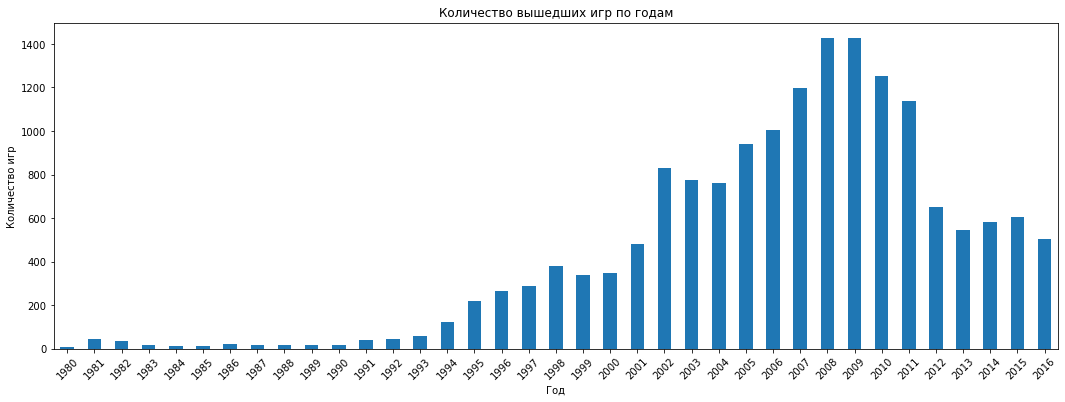

In [24]:
# сгруппируем данные по годам и построим для наглядности график выхода игр
good_df.groupby('release').release.count().plot(kind='bar', 
                                                figsize=(18,6), 
                                                xlabel='Год', 
                                                ylabel='Количество игр', 
                                                rot=45, 
                                                title='Количество вышедших игр по годам');


In [25]:
good_df.release.describe()

count    16444.000000
mean      2006.486256
std          5.875525
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: release, dtype: float64

Исходя из графика и таблицы распределения активность игроделов начала расти с 1993 года. Пик ее наступил в 2008 - 2009 годах, а в 2012 году произошел резкий спад. Далее посмотрим с чем это может быть связано. Что послужило причиной таких скачков на графике мы разберемся далее.

### 3.2. Изменение продаж по платформам.

In [26]:
# выведем топ10 платформ по продажам за весь период и сохраним их в переменную
top_platforms = good_df.groupby('platform').agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False).head(10)
top_platforms

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


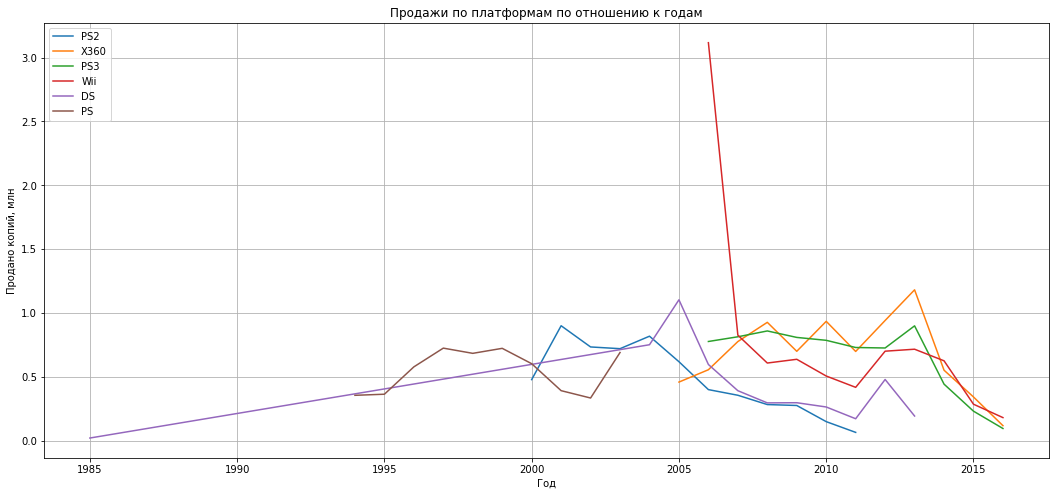

In [27]:
# построим график распределения общих прибылей для топ6 платформ из таблицы выше
fig,ax = plt.subplots()

for i in top_platforms.index[:6].tolist():
    ax.plot(good_df[good_df['platform'] == i].pivot_table(index='release',values='total_sales'), label=i )

ax.legend(loc='upper left')
ax.set_xlabel('Год')
ax.set_ylabel('Продано копий, млн')
ax.set_title('Продажи по платформам по отношению к годам')
ax.grid(True)
fig.set_figheight(8)
fig.set_figwidth(18)

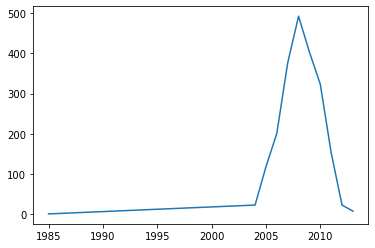

In [28]:
fig,ax = plt.subplots()

ax.plot(good_df[good_df['platform'] == 'DS'].pivot_table(index='release',values='total_sales', aggfunc='count'), label='ds' );


Из таблицы выше следует, что средний цикл жизни каждой платформы составляет примерно 10 лет. За исключением платформы "DS" - ее жизненный цикл, исходя из графика, составил более 25 лет. Как раз в 2012-2013 годах закончился жизненный цикл платформ PS2 и DS, что и могло привести к такому резкому спаду выпускаемых игры на графике предыдущего раздела.

### 3.3. Выбор актуального периода и определение лидирующих платформ в данном периоде.

Исходя из распределений обоих графиков выше считаю, что за актуальный период можно брать период с 2012 года включительно и позднее. Но данные за 2016й год представлены не полностью, поэтому считаю стоит посмотреть меняет ли включение их в выборку общую картину

In [29]:
# оставляем все строки с играми, которые были выпущены в период с 2012 года и до 2015 год включительно
actual_df_2015 = good_df[(good_df['release'] >= 2012) & (good_df['release'] < 2016)]
actual_df_2015.shape

(2384, 13)

In [30]:
# отсекаем все строки с играми, которые были выпущены ранее 2012 года
actual_df_2016 = good_df[good_df['release'] >= 2012]
actual_df_2016.shape

(2886, 13)

In [31]:
# выведем топ5 лидирующих по продажам платформ актуального периода 2012 - 2015
df_2015 = actual_df_2015.groupby('platform').agg({'total_sales':'sum'}) \
                                  .sort_values('total_sales', ascending=False) \
                                  .rename(columns={'total_sales':'sales_2015'}).head()
df_2015

,sales_2015
platform,
PS3,285.19
PS4,244.89
X360,235.02
3DS,179.47
XOne,133.17


In [32]:
# выведем топ5 лидирующих по продажам платформ актуального периода 2012 - 2016
df_2016 = actual_df_2016.groupby('platform').agg({'total_sales':'sum'}) \
                                  .sort_values('total_sales', ascending=False) \
                                  .rename(columns={'total_sales':'sales_2016'}).head()
df_2016

,sales_2016
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32


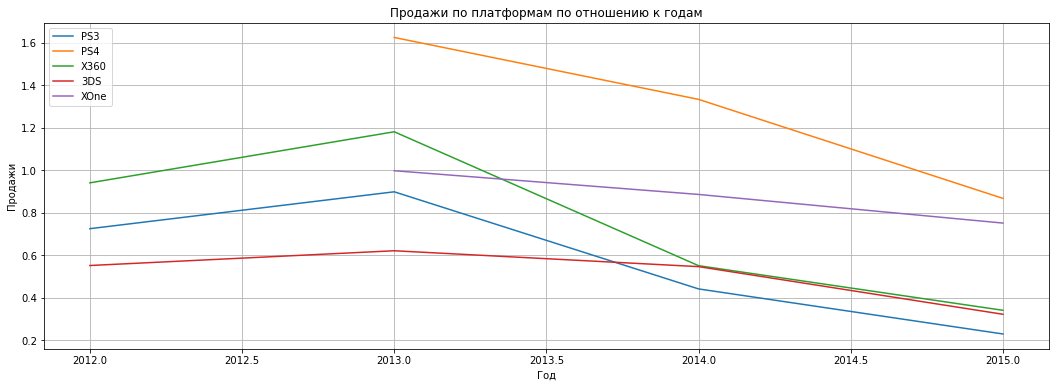

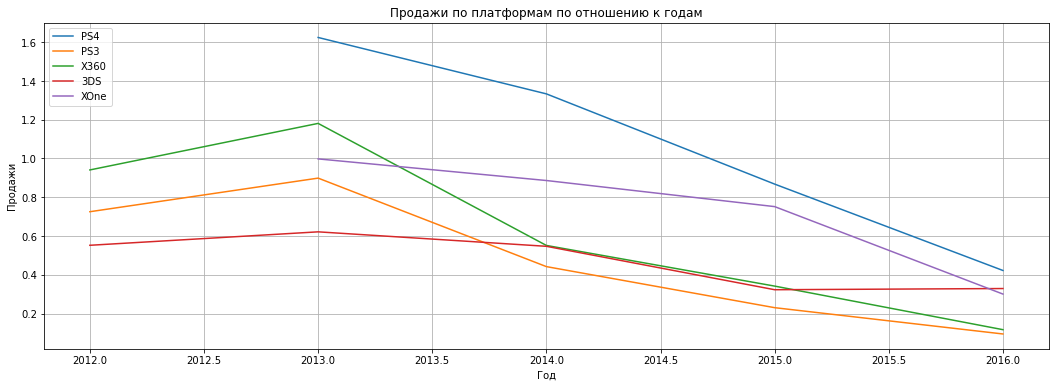

In [33]:
# на основе обеих таблиц сделаем графики, отображающие распределение продаж по годам в обоих вариантах,
# чтобы можно было выбрать наиболее оптимальный вариант
# график по данным периода 2012 - 2015
fig,ax = plt.subplots()

for i in df_2015.index[:6].tolist():
    ax.plot(actual_df_2015[actual_df_2015['platform'] == i].pivot_table(index='release',values='total_sales'), label=i)

    ax.legend(loc='upper left')
ax.set_xlabel('Год')
ax.set_ylabel('Продажи')
ax.set_title('Продажи по платформам по отношению к годам')
ax.grid(True)
fig.set_figheight(6)
fig.set_figwidth(18)
plt.show()
# график по данным периода 2012 - 2016
fig,ax = plt.subplots()

for i in df_2016.index[:6].tolist():
    ax.plot(actual_df_2016[actual_df_2016['platform'] == i].pivot_table(index='release',values='total_sales'), label=i )

ax.legend(loc='upper left')
ax.set_xlabel('Год')
ax.set_ylabel('Продажи')
ax.set_title('Продажи по платформам по отношению к годам')
ax.grid(True)
fig.set_figheight(6)
fig.set_figwidth(18)

Оба графика показывают примерно одинаковую картину - с 2013 года все платформы начинают падать в продажах. Но за период с 2015 года как минимум одна платформа выходит на стабильный уровень и перестает снижаться в продажах. Поэтому, несмотря на неполные данные за 2016й год, считаю допустимым взять в дальнейшую работу актуальный период 2012 - 2016 годы.

В дальнейшем будем работать с переменной actual_df_2016, т.к. в ней как раз и остались строки, которые представляют интересующий нас актуальный период.

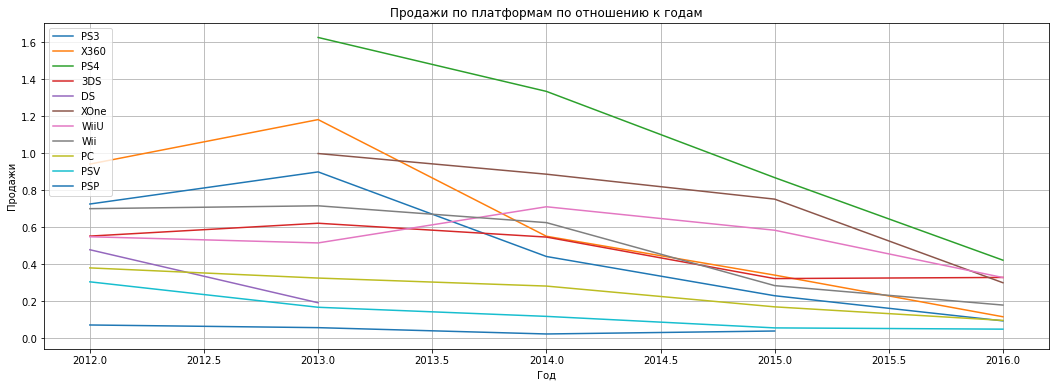

In [34]:
# построим тот же график для всех платформ, которые имеют продажи в период с 2012 года и позднее
fig,ax = plt.subplots()
for i in actual_df_2016.platform.unique():
    ax.plot(actual_df_2016[actual_df_2016['platform'] == i].pivot_table(index='release',values='total_sales'), label=i)
ax.legend(loc='upper left')
ax.set_xlabel('Год')
ax.set_ylabel('Продажи')
ax.set_title('Продажи по платформам по отношению к годам')
ax.grid(True)
fig.set_figheight(6)
fig.set_figwidth(18)


При визуализации продаж по всем платформам, попадающим в выборку с 2012 по 2016 годы мы видим, что не только "3DS", как на предыдущем графике, но и "PSV" показывают стабильный уровень продаж с 2015 года, но у PSV уровень продаж на порядок ниже, чем у 3DS. Остальные платформы показывают стабильное снижение продаж от года к году.

### 3.4. Распределение продаж по платформам.

Для общей первичной оценки построим боксплот по всем продажам.

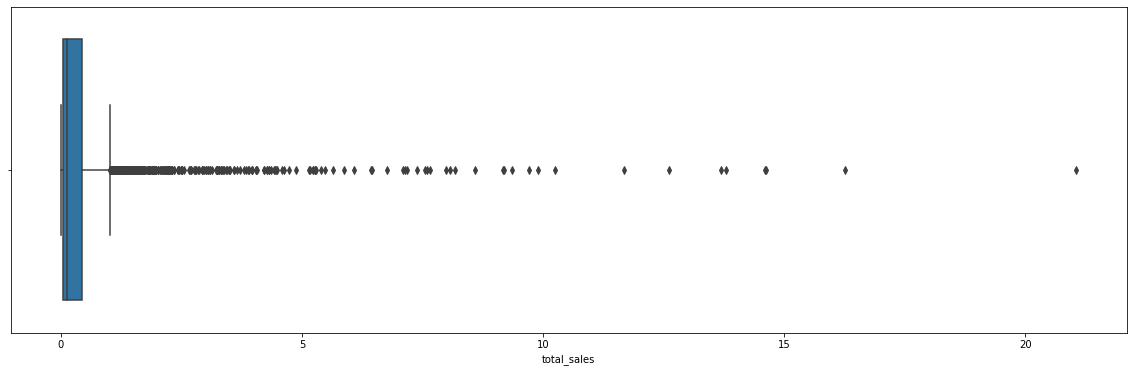

In [35]:
plt.figure(figsize=(20, 6))
sns.boxplot(x=actual_df_2016['total_sales']);

В силу большого количества выбросов - продаж хитовых игр огромным количеством копий, данный график не является показательным и на нем довольно сложно что-либо увидеть.
Поэтому считаю имеет смысл посмотреть общее распределение проданных игр и уже на основании этого распредления строить боксплоты по каждой из платформ.

In [36]:
actual_df_2016['total_sales'].describe()

count    2886.000000
mean        0.501223
std         1.249157
min         0.010000
25%         0.040000
50%         0.120000
75%         0.430000
max        21.050000
Name: total_sales, dtype: float64

In [37]:
# посчитаем верхнюю границу "усов" общего распределения продаж
np.percentile(actual_df_2016['total_sales'],75) + \
(np.percentile(actual_df_2016['total_sales'],75) - \
 np.percentile(actual_df_2016['total_sales'],25))

0.8200000000000001

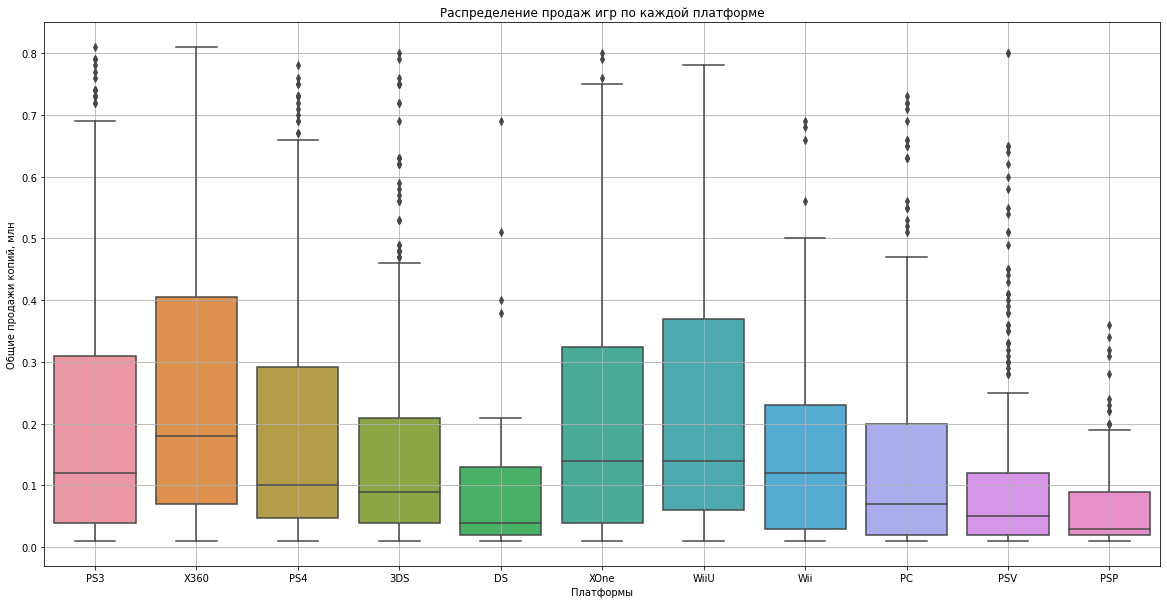

In [38]:
# беря в расчет верхнюю границу распределения, строим графики распределения по каждой из платформ за весь актуальный период
plt.figure(figsize=(20, 10))
sns.boxplot(y=actual_df_2016[actual_df_2016['total_sales'] < 0.82]['total_sales'], x=actual_df_2016['platform']);
plt.grid(True)
plt.xlabel('Платформы')
plt.ylabel('Общие продажи копий, млн')
plt.title('Распределение продаж игр по каждой платформе');

Исходя из графиков выше, которые исключают выбросы в виде кассовых игр с большим объемом продаж, отчетливо видно, что лидерами по объемам продаж своих игр являются платформы "X360" и "WiiU", за ними следуют "PS3", "PS4" и "XOne". Остальные платформы довольно значительно отстают в общем объеме продаж в периоде с 2012 по 2016й годы.

для большей детализации нижних границ графиков ограничим график по шкале Y на уровне 0.3

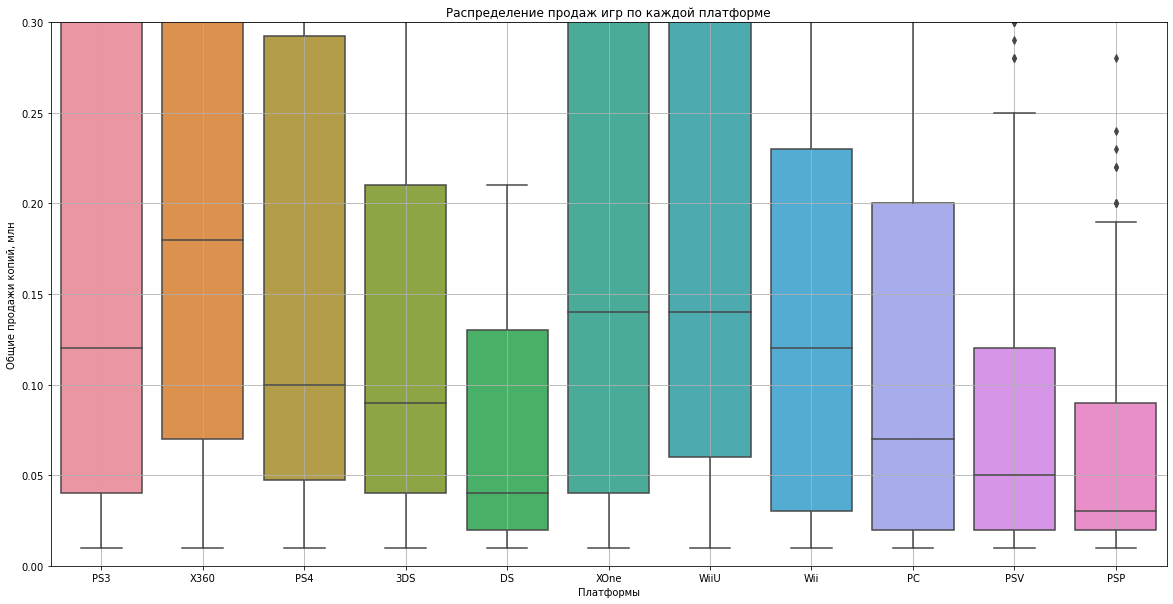

In [39]:
plt.figure(figsize=(20, 10))
sns.boxplot(y=actual_df_2016[actual_df_2016['total_sales'] < 0.82]['total_sales'], x=actual_df_2016['platform']);
plt.grid(True)
plt.xlabel('Платформы')
plt.ylabel('Общие продажи копий, млн')
plt.title('Распределение продаж игр по каждой платформе')
plt.ylim(0,0.3);

На "увеличенном" графике мы можем видеть, что медиана продаж как минимум 3х платформ (PSP, PSV, DS) не превышает значения в 50 тыс. копий, в промежутке между 50 и 100 тыс копий находятся платформы - PC, 3DS, PS4, далее идет интервал 100 - 150 тыс. копий, там располагаются Wii, WiiU, XOne, PS3, ну и самое высокое медианное значение по продажам показала платформа X360.

### 3.5. Корреляция продаж и отзывов.

Проверим есть ли зависимость между отзывами покупателей/критиков и продажами по лидирующим платформам

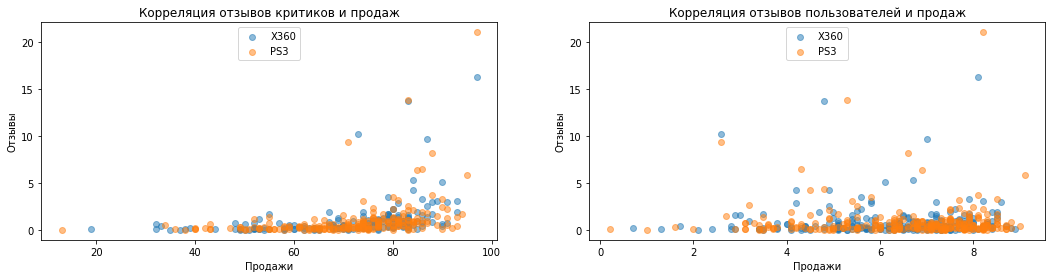

In [40]:
#сделаем выборки по 2м лидирующим в продажах платформам
df_x360 = actual_df_2016.query('platform == "X360"')
df_ps3 = actual_df_2016.query('platform == "PS3"')
# построим график рассеяния для обеих категорий оценок (покупатели/критики)
fig, ax = plt.subplots(1,2);
fig.set_figheight(4)
fig.set_figwidth(18)

# график для критиков
plt.subplot(1,2,1)
plt.scatter(y=df_x360.total_sales, x=df_x360.critic_score, alpha=0.5, label='X360');
plt.scatter(y=df_ps3.total_sales, x=df_ps3.critic_score, alpha=0.5, label='PS3');
plt.xlabel('Продажи')
plt.ylabel('Отзывы')
plt.legend(loc=9)
plt.title('Корреляция отзывов критиков и продаж');


# график для пользователей
plt.subplot(1, 2, 2)
plt.scatter(y=df_x360.total_sales, x=df_x360.user_score, alpha=0.5, label='X360');
plt.scatter(y=df_ps3.total_sales, x=df_ps3.user_score, alpha=0.5, label='PS3');
plt.xlabel('Продажи')
plt.ylabel('Отзывы')
plt.legend(loc=9)
plt.title('Корреляция отзывов пользователей и продаж');


На графиках по обеим платформам видно довольно слабую или совсем отсутствующую корреляцию между отзывами и продажами.
Для того, чтобы окончательно в этом убедиться проверим это в цифрах.

In [41]:
# посчитаем коэффициент корреляции для платформы "x360"
print(f'Корреляция между отзывами критиков и продажами x360: {df_x360.total_sales.corr(df_x360.critic_score)}')
print(f'Корреляция между отзывами критиков и продажами PS3: {df_ps3.total_sales.corr(df_ps3.critic_score)}')

print()
# посчитаем коэффициент корреляции для платформы "PS3"
print(f'Корреляция между отзывами пользователей и продажами PS3: {df_ps3.total_sales.corr(df_ps3.user_score)}')
print(f'Корреляция между отзывами пользователей и продажами x360: {df_x360.total_sales.corr(df_x360.user_score)}')


Корреляция между отзывами критиков и продажами x360: 0.36057348885073387
Корреляция между отзывами критиков и продажами PS3: 0.33149725926295903

Корреляция между отзывами пользователей и продажами PS3: -0.005143522887113828
Корреляция между отзывами пользователей и продажами x360: 0.0061639786462133585


В итоге мы можем сделать вывод, что оценки критиков демонстрируют прямую, средне-слабую корреляцию со значениями продаж. Оценки пользователей корреляции с продажами не имеют. Исходя из проведенного анализа 2х лидирующих по продажам платформ, можно предположить, что на всех остальных, менее успешных, платформах, будет примерно та же самая картина.

### 3.6. Распределение игр по жанрам.

Посмотрим как в целом распределяются игры в зависимости от жанра.

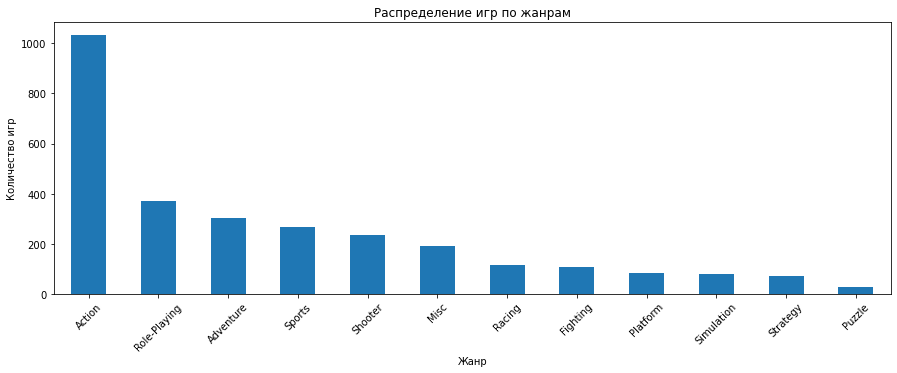

In [42]:
actual_df_2016.groupby('genre').genre.count().sort_values(ascending=False) \
              .plot(kind='bar',
                    rot=45,xlabel='Жанр',
                    ylabel='Количество игр',
                    title='Распределение игр по жанрам',
                    figsize=(15,5));

На графике видно, что сильно лидирует по количеству игр жанр Action. Посмотрим теперь какое распределение имеют продажи игр по жанрам.

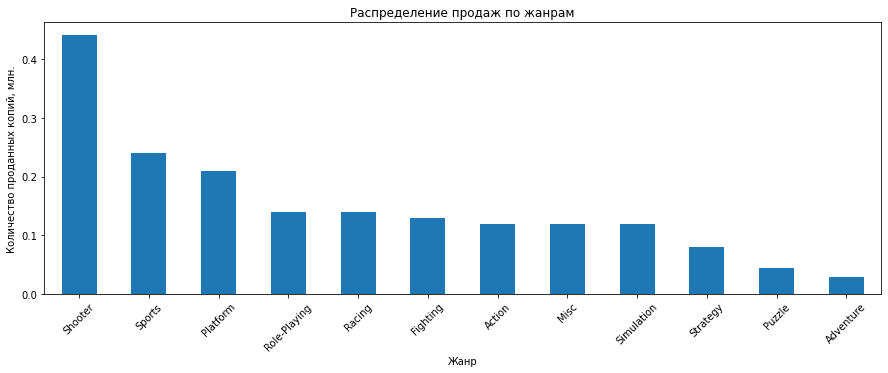

In [43]:
actual_df_2016.groupby('genre').total_sales.median().sort_values(ascending=False) \
              .plot(kind='bar',
              rot=45,xlabel='Жанр',                
              ylabel='Количество проданных копий, млн.',
              title='Распределение продаж по жанрам',
              figsize=(15,5));

Как видно из графика, жанр Shooter уверенно лидирует в графике по продажам игр.Наименее продаваемыми и разнообразными по количеству игр являются жанры Strategy и Puzzle - они занимают последние строчки в обоих списках. Немного отличается ситуация с жанром Adventure, т.к. по количеству выпущенных игр данный жанр занимает 3е место, а вот по продажам этот жанр стоит на последнем месте. А жанры Sports, занимая 4е место по количеству игр становится на 2е место по продажам, и Shooter, находясь на 5м месте по количеству игра занимает 1е место по их продажм. Это говорит нам о том, что количество проданных копий игр определенного жанра не всегда напрямую зависит от общего количества игр этого жанра. Также исходя из обоих этих графиков можно сделать вывод, что самыми перспективными жанрами в игровой индустрии являются Shooter и Sports.

<a id='section4'></a>
## 4. Примерный портрет пользователя каждого региона.

Используя данные по продажам по каждому региону попробуем составить примерный портрет пользователя каждого региона, а именно:
 * Самые популярные платформы (топ-5). Опишите различия в долях продаж.
 * Самые популярные жанры (топ-5). Поясните разницу.
 * Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### 4.1. Популярность платформы в зависимости от рынка.

Посмотрим какие платформы популярны для какого рынка.

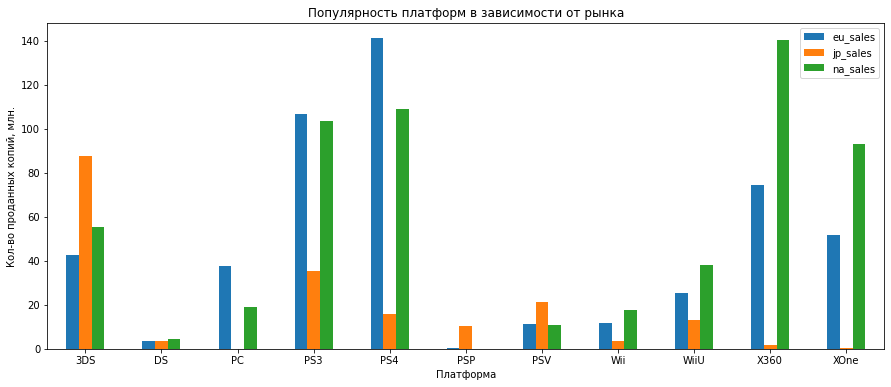

In [44]:
# Построим общий график распределения продаж по всем платформам и всем трем рынкам
actual_df_2016.pivot_table( index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum') \
              .plot(kind='bar',
                    figsize=(15, 6),
                    rot=360,
                    xlabel='Платформа',
                    ylabel='Кол-во проданных копий, млн.',
                    title='Популярность платформ в зависимости от рынка');

На общем графике популярности платформ видно, что лидируют 5 плафторм - это 3DS, PS3, PS4, X360, XOne. Как именно они распределяются на каждом из рынков посмотрим ниже, построив отдельный график по каждому рынку.

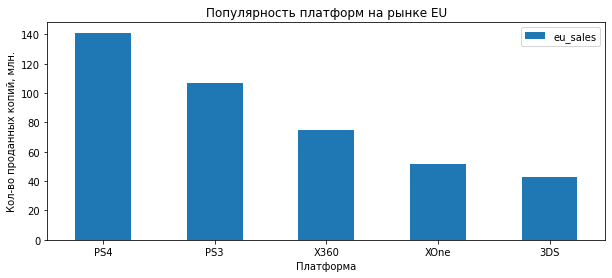

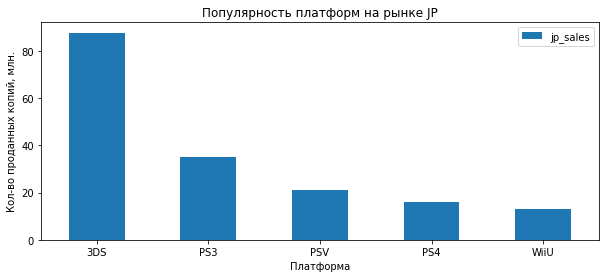

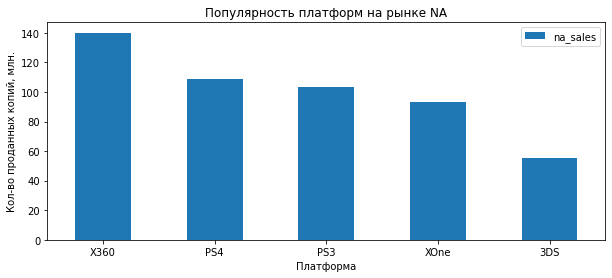

In [45]:
# построим графики с топ5 платформ для каждого рынка по отдельности
for market in ['eu_sales','jp_sales','na_sales']:
    actual_df_2016.pivot_table(index='platform', values=market , aggfunc='sum') \
                  .sort_values(market,ascending=False) \
                  .head() \
                  .plot(kind='bar',
                        figsize=(10, 4),
                        rot=360, xlabel='Платформа',
                        ylabel='Кол-во проданных копий, млн.',
                        title=f'Популярность платформ на рынке {market[:2].upper()}');
                        


Из данных графиков получается, что на рынках EU и NA больше востребованы такие платформы, как PS3, PS4 и X360, в то время как на рынке JP больше востребованы портативные платформы, такие как 3DS и PSV, но там также актуальна платформа PS3.



### 4.2. Популярность жанра в зависимости от рынка.

Теперь посмотрим какие жанры востребованы на этих рынках

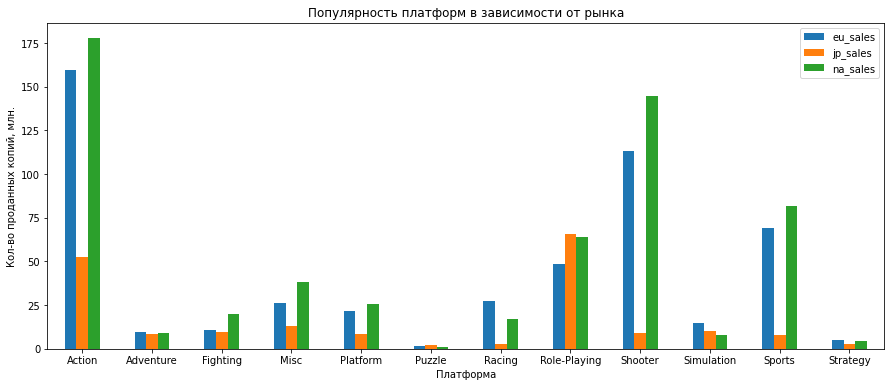

In [46]:
# Построим общий график распределения продаж по всем платформам и всем трем рынкам
actual_df_2016.pivot_table( index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum') \
              .plot(kind='bar',
                    figsize=(15, 6),
                    rot=360,
                    xlabel='Платформа',
                    ylabel='Кол-во проданных копий, млн.',
                    title='Популярность платформ в зависимости от рынка');

По общей картине видно, что самые популярные жанры в целом это Action, Music, Role-Playing, Shooter и Sports.
Посмотрим насколько они популярны на каждом рынке в отдельности и есть ли разница в жанрах от рынка к рынку.

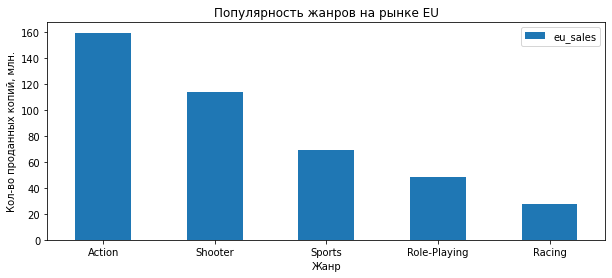

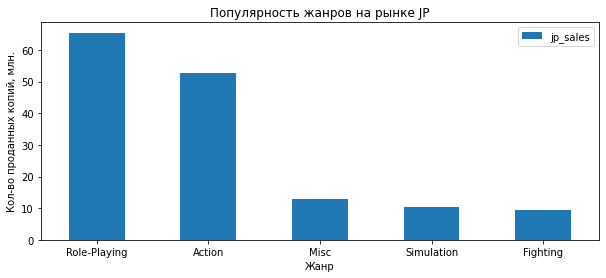

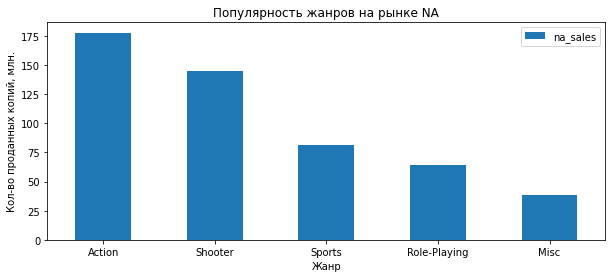

In [47]:
# построим графики с топ5 платформ для каждого рынка по отдельности
for market in ['eu_sales','jp_sales','na_sales']:
    actual_df_2016.pivot_table(index='genre', values=market , aggfunc='sum') \
                  .sort_values(market,ascending=False) \
                  .head() \
                  .plot(kind='bar',
                        figsize=(10, 4),
                        rot=360, xlabel='Жанр',
                        ylabel='Кол-во проданных копий, млн.',
                        title=f'Популярность жанров на рынке {market[:2].upper()}');

Из графиков выше видно, что рынок NA и рынок EU почти идентичны в своих предпочтениях, а вот рынок JP довольно сильно отличается от других - там популярны другие жанры. Выбор игр в зависимости от жанра различается от жанра к жанру.

<a id='section7'></a>
### 4.3. Зависимость продаж от рейтинга игр по регионам.

Построим общий график, отображающий количество продаж по регионам, в зависимости от возрастного рейтинга

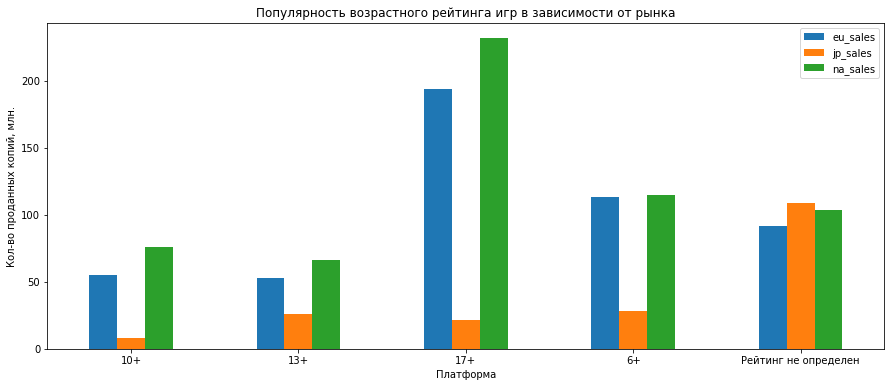

In [48]:
actual_df_2016.pivot_table( index='age_rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum') \
              .plot(kind='bar',
                    figsize=(15, 6),
                    rot=360,
                    xlabel='Платформа',
                    ylabel='Кол-во проданных копий, млн.',
                    title='Популярность возрастного рейтинга игр в зависимости от рынка');

Из графика видно, что явным лидером по продажам во всех регионах являются игры с рейтингом 17+.
Для более наглядной картины, посмотрим как распределились рейтинги на каждом из рынков.

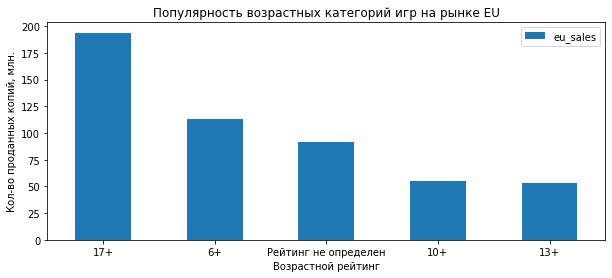

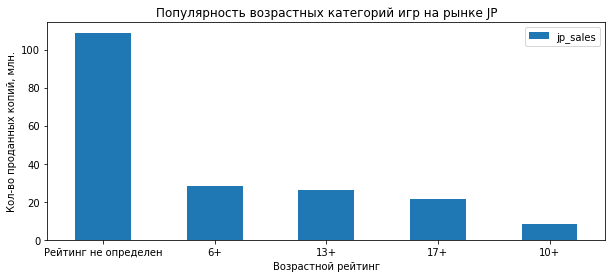

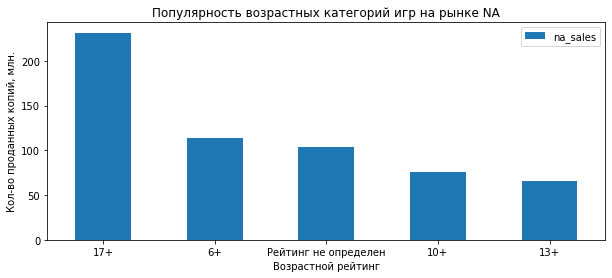

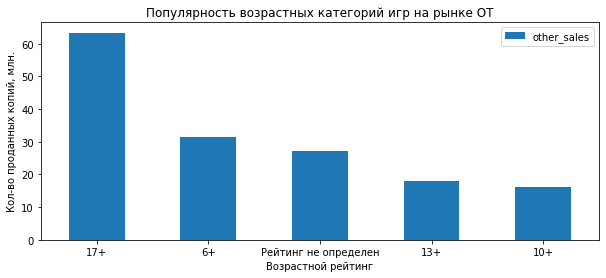

In [49]:
# построим графики с топ5 платформ для каждого рынка по отдельности
for market in ['eu_sales','jp_sales','na_sales', 'other_sales']:
    actual_df_2016.pivot_table(index='age_rating', values=market , aggfunc='sum') \
                  .sort_values(market,ascending=False) \
                  .head() \
                  .plot(kind='bar',
                        figsize=(10, 4),
                        rot=360, xlabel='Возрастной рейтинг',
                        ylabel='Кол-во проданных копий, млн.',
                        title=f'Популярность возрастных категорий игр на рынке {market[:2].upper()}');

Исходя из графиков выше следует, что на рынках EU и NA лидирует с большим отрывом по популярности рейтинг 17+. Рынки NA и UE в целом довольно схожи и по интересам и их количественным распределениям. Характерной же особенностью рынка JP, как мы видим, является то, что лидируют там игры без рейтинга. Соответственно кажется логичным следующий вывод - Большое количество игр без рейтинга на рынке JP обусловлено тем, что организация ESRB в основном присваивает рейтинги играм рынков NA, EU и OTHER (по инофрмации из википедии они занимаются оценкой ПО в первую очередь в Америке и Канаде), Этим, скорее всего, и объясняется та аномалия, что большинство игр рынка JP, не смотря на лидирующие строчки в некоторых случаях, в основном не имеют рейтинга.

**Вывод:** Исходя из проведенного анализа мы можем сделать следующие выводы о рынках игровой индустрии:
* Рынки NA и UE похожи между собой и довольно сильно отличаются от рынка JP
* На рынках NA и UE покупатели больше интересуются играми жанров Action, Shooter, Sport на платформах PS4, PS3 и X360 и возрастной категории 17+
* Рынок JP сильно отличается от других и там больше востребованы игры жанров Role-Play, Action на портативных платформах 3DS и PSV, а также платформа PS3, рейтинги возрастных ограничений на данном рынке часто не указывается в играх.

<a id='section5'></a>
## 5. Проверка гипотез.

**Гипотеза №1:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Проверим данную гипотезу на основе выборок из генеральной совокупности без пропущенных значений.

Соответственно нулевая гипотеза будет звучать как : "Среднее значение пользовательского рейтинга Xbox One равняется среднему значению пользовательского рейтинга PC"

Тогда альтернативная гипотеза будет звучать как: "Среднее значение пользовательского рейтинга Xbox One НЕ равняется среднему значению пользовательского рейтинга PC" (т.е. отличается в большую или меньшую сторону)

В случае, если нулевая гипотеза будет подтверждена, т.е. если p-value будет выше статистического уровня значимости, у нас будет достаточно оснований принять нулевую гипотезу, а соответственно быть уверенными в том, что средние значения двух выборок равны.

In [50]:
# посчитаем значение P-value на основании проведененного t-теста и сравним его с предельным уровнем статзначимости
alpha = 0.05
results = st.ttest_ind(actual_df_2016.query('platform == "XOne" and user_score.notna()')['user_score'],
                       actual_df_2016.query('platform == "PC" and user_score.notna()')['user_score'])
print('p-значение:', results.pvalue)
# если уровень значимости будет больше, чем значение p-value, тогда отвергнем нулевую гипотезу и примем альтернативную
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Т.к. отвергнуть нулевую гипотезу нет достаточных оснований можем сделать вывод, что средние значения скорей всего равны, соответственно наша гипотеза подтвердилась.

**Гипотеза №2:** Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Проверим данную гипотезу на основе выборок из генеральной совокупности без пропущенных значений.

Соответственно нулевая гипотеза будет звучать как : "Среднее значение пользовательского рейтинга Action равняется среднему значению пользовательского рейтинга Sports"

Тогда альтернативная гипотеза будет звучать как: "Среднее значение пользовательского рейтинга Action НЕ равняется среднему значению пользовательского рейтинга Sports" (т.е. отличается в большую или меньшую сторону).

В отличие от предыдущей гипотезы, здесь же наоборот, наша гипотеза будет верна в том случае, если мы сможем отвергнуть нулевую гипотезу о равенстве средних значений в пользу альтернотивно гипотезы о их разности.

In [51]:
# посчитаем значение P-value на основании проведененного t-теста и сравним его с предельным уровнем статзначимости
alpha = 0.05
results = st.ttest_ind(actual_df_2016.query('genre == "Action" and user_score.notna()')['user_score'],
                       actual_df_2016.query('genre == "Sports" and user_score.notna()')['user_score'])
print('p-значение:', results.pvalue)
# если уровень значимости будет больше, чем значение p-value, тогда отвергнем нулевую гипотезу и примем альтернативную
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Проведенный тест показал, что у нас есть достаточно оснований, чтобы отвергнуть нулевую гипотезу о равенстве средних значений двух выборок. Поэтому мы принимаем альтернативную гипотезу и можем считать, что средние значения,скорее всего, разные.

В обеих гипотезах для их проверки применялся t-тест стьюдента, т.к. он больше всего подходит для проверки равенства средних двух независимых выборок.

<a id='section6'></a>
## Общий вывод

На основании проведенного анализа можно утверждать:
* что количество выпущенных на какой-либо платформе игр не гарантирует нам наибольшего количества покупок по этой платформе.
* что отсутствие рейтинга не говорит о том, что игра не популярна на определенном рынке (<a href='#section7'>см. пункт 4.3</a>).
* что рынки NA и EU довольно сильно похожи по своим запросам, в то время, как рынок JP стоит особняком и довольно сильно отличается от других. 

В то же время, исходя из графиков продаж игр видно, что почти все платформы показывают снижение интереса покупателей к их играм. Единственные, кто с 2015 года перестали снижаться в показателях и показывают примерно одинаковый уровень, это портативные платформы 3DS и PSV, что говорит о том, что рынок JP, на котором как раз данные платформы наиболее востребованны, более перспективный.



Подводя общий итог нашего исследования, целью которого являлось определение наиболее перспективных направлений для дальнейшего развития компании, можно предполагать следующее:
* наиболее прибыльными жанрами за период с 2012 по 2016 год являются - Shooter и Sports
* в случае выхода на рынки NA или EU - наиболее популярны игры жанров Action, Shooter и Sports, выпущенные на платформах выпущенные на платформах PS4, PS3 и X360 c возрастными ограничениями 17+.
* в случае выхода на рынок JP - наиболее популярны игры в жанрах Role-Play, Action, выпущенные на платформах 3DS,  PSV и PS3 без учета возрастных ограничений.